## Sagnac Frequency - Backscatter Correction - RZ FSR

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv, DatetimeIndex
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d


In [2]:
from functions.read_sds import __read_sds
from functions.read_yaml import __readYaml
from functions.load_furt_stream import __load_furt_stream
from functions.smoothing import __smooth
from functions.interpolate_nan import __interpolate_nan
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data
from functions.conversion_to_tilt import __conversion_to_tilt
from functions.load_water_level import __load_water_level
from functions.load_beam_wander_data import __load_beam_wander_data
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals


In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [4]:
config = {}

config['ring'] = "Z"

config['delta'] = 60

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"


# with GPS reference and new settings
config['tbeg'] = UTCDateTime("2024-09-09 12:00")
config['tend'] = UTCDateTime("2024-09-13 00:00")
config['flim1'], config['flim2'] = 553.574, 553.585


# path to Sagnac data
# config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"manuscripts/manuscript_romy_drifts/data/"

# config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"manuscripts/manuscript_romy_drifts/figures/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

### Load Backscatter Data

In [5]:
bs = read_pickle(config['path_to_data']+"bs_fsr_ex3.pkl")

# update time seconds
bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - config['tbeg'])

bs = bs[(bs.time1 >= config['tbeg']) & (bs.time2 <= config['tend'])]


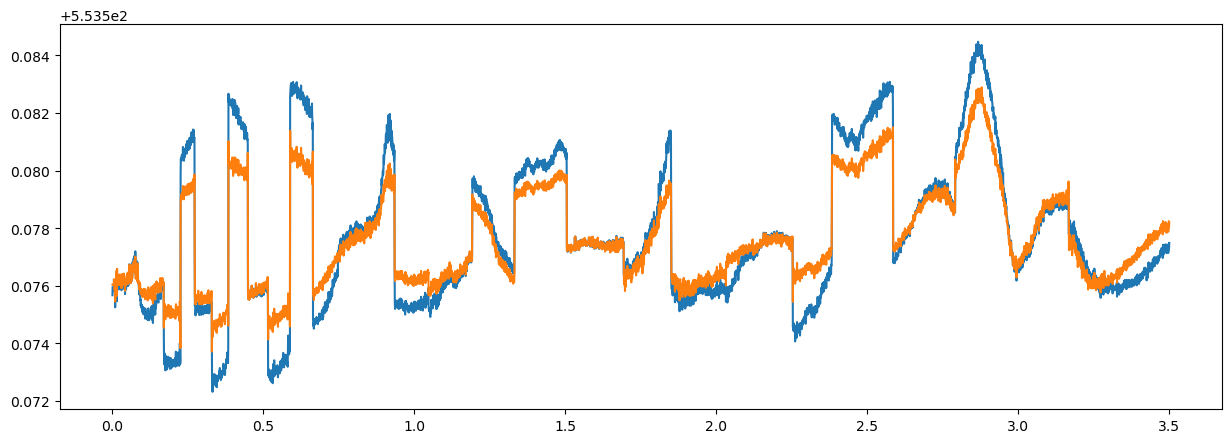

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.plot(bs.time_sec/86400, bs.fj_bs)

# plt.plot(bs.time_sec/86400, gaussian_filter1d(bs.fj_bs, 2))

# plt.ylim(config['flim1'], config['flim2'])

### Load WROMY Data

In [7]:
# ws = Stream()
# ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.01.LKI", config['tbeg'], config['tend'])
# ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.05.LKI", config['tbeg'], config['tend'])
# ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.09.LKI", config['tbeg'], config['tend'])

# ws = ws.merge();

# ws

### Load PROMY Data

In [8]:
ps = Stream()
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.01.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.03.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.05.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.07.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", config['tbeg'], config['tend'])

ps3 = ps.merge();

ps

5 Trace(s) in Stream:
BW.PROMY.01.LKI | 2024-09-09T12:00:00.000000Z - 2024-09-12T23:59:59.000000Z | 1.0 Hz, 302400 samples
BW.PROMY.03.LKI | 2024-09-09T12:00:00.000000Z - 2024-09-12T23:59:59.000000Z | 1.0 Hz, 302400 samples
BW.PROMY.05.LKI | 2024-09-09T12:00:00.000000Z - 2024-09-12T23:59:59.000000Z | 1.0 Hz, 302400 samples
BW.PROMY.07.LKI | 2024-09-09T12:00:00.000000Z - 2024-09-12T23:59:59.000000Z | 1.0 Hz, 302400 samples
BW.PROMY.09.LKI | 2024-09-09T12:00:00.000000Z - 2024-09-12T23:59:59.000000Z | 1.0 Hz, 302400 samples

### Load LXX Data

In [9]:
# load log data
lxx = __load_lxx(config['tbeg'], config['tend'], archive_path)

# make intervals
lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

### Load Beam Wander Data

In [10]:
df01 = read_pickle(config['path_to_data']+"ids01_fsr.pkl")

df03 = read_pickle(config['path_to_data']+"ids03_fsr.pkl")

df05 = read_pickle(config['path_to_data']+"ids05_fsr.pkl")

In [11]:
def __process(df0):

    # cut to time period
    df0 = df0[(df0.time_utc >= config['tbeg']) & (df0.time_utc <= config['tend'])]

    df0.loc[:, 'y_um_rel'] = __reduce(df0.y_um_rel, 3)
    df0.loc[:, 'x_um_rel'] = __reduce(df0.x_um_rel, 3)

    df0.reset_index(drop=True, inplace=True)
    return df0

df01 = __process(df01)
df03 = __process(df03)
df05 = __process(df05)


### Load Infrasound FFBI

In [12]:
ffbi = Stream()
ffbi += __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDF", config['tbeg'], config['tend'])
ffbi += __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDO", config['tbeg'], config['tend'])

In [13]:
ffbi_bdf_smooth1 = __smooth(ffbi.select(channel="*F")[0].data, int(60*ffbi.select(channel="*F")[0].stats.sampling_rate))
ffbi_bdf_smooth2 = __smooth(ffbi.select(channel="*F")[0].data, int(3600*ffbi.select(channel="*F")[0].stats.sampling_rate))

### Load FSR Data

In [14]:
fsr = read_pickle(config['path_to_data']+"romy_fsr_ex3.pkl")

fsr = fsr[(fsr.time_utc >= config['tbeg']) & (fsr.time_utc <= config['tend'])]

fsr['time_sec'] = [_t - config['tbeg'] for _t in fsr.time_utc]


## Plotting

In [15]:
gc.collect()

0

In [16]:
from functions.find_max_min import __find_max_min

In [17]:
from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
from scipy.signal import detrend 

N1, N2 = 50_000, 150_000
# N1, N2 = 0, 200_000

# prepare temperature
temp5 = ps.copy().select(location="05")[0]
temp7 = ps.copy().select(location="07")[0]
temp9 = ps.copy().select(location="09")[0]
x_data = temp5.data + temp7.data + temp9.data

# time temp
x_time = temp9.times(reftime=fsr.time_utc.iloc[0])

# interpolate temp data
x_data = np.interp(fsr.time_sec, x_time, x_data)

# prepare displacment data
disp = __interpolate_nan(fsr.disp_avg_rel.values)
y_data = disp

# smooth
y_data = __smooth(y_data, 7200, setpad=True)
x_data = __smooth(x_data, 24*3600, setpad=True)

temp_data_smooth = x_data

# trim
x_data = x_data[N1:N2]
y_data = y_data[N1:N2]

# reduce
x_data = __reduce(x_data, 10)
y_data = __reduce(y_data, 10)

# linear rtemp_data_smoothegression
x, y = x_data, y_data

# linear regression
outT = __compute_orthogonal_distance_regression(x, y)

# reduce temp data
temp_data_smooth -= np.nanmean(temp_data_smooth[N1:N1+10])
disp -= np.nanmean(disp[N1:N1+10])

print(outT[0]*1e6, outT[1]*1e6)

fsr['disp_detrend_temp'] = disp - ( outT[0] * temp_data_smooth + outT[1] )

fsr['disp_as_temp'] = (disp - outT[1]) / outT[0]

1000000.0 1000000.0


/home/andbro/notebooks/SagnacFrequency/functions/reduce.py:4: RuntimeWarning: Mean of empty slice
  return dat - nanmean(_dat[:n_samples])
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/numpy/core/_methods.py:198: Runtime

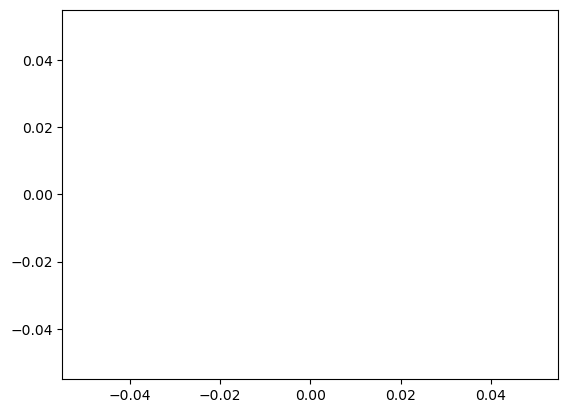

In [18]:
plt.scatter(temp_data_smooth, disp)
plt.scatter(x, y, s=.1)
plt.plot(x, outT[1] + x * outT[0], "k")

### Plotting

In [19]:
from functions.get_stream import __get_stream
from functions.interpolate_nan import __interpolate_nan

In [21]:
def __makeplot_fsr2():

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from functions.reduce import __reduce
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    reftime = config['tbeg']

    tscale, tunit = 1/86400, "days"

    fsrscale, fsrunit = 1e6, "$\mu$m"

    fscale, funit = 1e3, "mHz"

    Ncol, Nrow = 1, 6

    font = 10

    fig, (ax0, ax1, ax5, ax2, ax3, ax4) = plt.subplots(Nrow, Ncol, figsize=(12, 10), sharex=True)

    plt.subplots_adjust(hspace=0.15)

    # __________________________________________________________________________________________________

    ax0.plot((bs.time1 - reftime)*tscale, __reduce(bs.fj_bs*fscale, 60), color="tab:red", label="RZ w/o backscatter", alpha=0.6)
    ax0.ticklabel_format(useOffset=False)
    ax0.plot((bs.time1 - reftime)*tscale, __reduce(bs.fj_bs_dejump*fscale, 60), color="k", label="RZ w/o backscatter w/o jumps)")
    ax0.ticklabel_format(useOffset=False)
    # ax0.set_ylim(top=25)

    # __________________________________________________________________________________________________

    ax5.plot(stx.select(station="FSR")[0].times(reftime=reftime)*tscale,
             stx.select(station="FSR")[0].data*fsrscale,
             color="purple", label=f"$\Delta$P (highpass > 24 hours)",
            )
    # ax5.set_ylim(-.2, .2)

    # __________________________________________________

    ax555 = ax5.twinx()

    ax555.plot(stx.select(station="FFBI")[0].times(reftime=reftime)*tscale,
             stx.select(station="FFBI")[0].data,
             color="darkred", label=f"Pressure (highpass > 24 hours)",
            )

    ax555.tick_params(axis='y', colors="darkred")
    ax555.set_ylabel("Air Pressure (hPa)", color="darkred")
    ax5.set_yticks(np.linspace(ax5.get_yticks()[0], ax5.get_yticks()[-1], len(ax5.get_yticks())))
    ax555.set_yticks(np.linspace(ax555.get_yticks()[0], ax555.get_yticks()[-1], len(ax5.get_yticks())))

    # __________________________________________________________________________________________________

    lbl = f"$\Delta$P - ( {round(outT[0]*1e6, 1)}$\mu$m/°C x $\Delta$T + {round(outT[1]*1e6, 1)} $\mu$m)"
    ax1.plot((fsr.time_utc - reftime)*tscale, fsr.disp_detrend_temp*fsrscale,
             color="purple", label=lbl, ls="--")
    # ax1.set_ylim(-2, 1)

    # __________________________________________________________________________________________________

    ax111 = ax1.twinx()
    ax111.plot(ffbi.select(channel="*O")[0].times(reftime=reftime)*tscale,
               ffbi.select(channel="*O")[0].data, color="darkred"
              )
    # ax111.plot(stx.select(channel="*O")[0].times(reftime=reftime)*tscale,
    #            stx.select(channel="*O")[0].data, color="darkred", ls="--"
    #           )
    ax111.tick_params(axis='y', colors="darkred")
    ax111.set_ylabel("Air Pressure (hPa)", color="darkred")
    ax1.set_yticks(np.linspace(ax1.get_yticks()[0], ax1.get_yticks()[-1], len(ax1.get_yticks())))
    ax111.set_yticks(np.linspace(ax111.get_yticks()[0], ax111.get_yticks()[-1], len(ax1.get_yticks())))

    # __________________________________________________________________________________________________

    ax2.scatter((df01.time_utc - reftime)*tscale, df01.y_um_rel, c="tab:blue",
                s=1, zorder=2, label="RZ (IDS01)", marker="o")
    ax2.scatter((df03.time_utc - reftime)*tscale, df03.y_um_rel, c="tab:orange",
                s=1, zorder=2, label="RZ (IDS03)", marker="^")
    ax2.scatter((df05.time_utc - reftime)*tscale, df05.y_um_rel, c="tab:red",
                s=1, zorder=2, label="RZ (IDS05)", marker="d")

    # __________________________________________________________________________________________________

    ax3.scatter((df01.time_utc - reftime)*tscale, df01.x_um_rel, c="tab:blue",
                s=1, zorder=2, label="RZ (IDS01)", marker="o")
    ax3.scatter((df03.time_utc - reftime)*tscale, df03.x_um_rel, c="tab:orange",
                s=1, zorder=2, label="RZ (IDS03)", marker="^")
    ax3.scatter((df05.time_utc - reftime)*tscale, df05.x_um_rel, c="tab:red",
                s=1, zorder=2, label="RZ (IDS05)", marker="d")

    # __________________________________________________________________________________________________

    for tr in ps.select(channel="*KI"):
        num = int(tr.stats.location[-1])
        if num not in [1, 3]:
            _dat = __smooth(tr.data, 300, setpad=True)
            _dat = __reduce(_dat, 10)
            ax4.plot(tr.times(reftime=reftime)*tscale, _dat,
                     color=config['colors'][num], label=f"PS{num}", alpha=0.7)
            if num in [5, 7, 9]:
                if num == 5:
                    temp_sum = _dat
                else:
                    temp_sum += _dat

    ax4.plot(tr.times(reftime=reftime)*tscale, temp_sum,
             color="k", ls="--", label=f"PS5+PS7+PS9", alpha=0.7)

    # ax4.set_ylim(-0.5, 2.2)

    ax4.plot((fsr.time_utc - reftime)*tscale, __reduce(fsr.disp_as_temp, 10),
             color="purple", label=f"$\Delta$P x {round(1/(outT[0]*1e3), 1)} m°C/$\mu$m")

    # __________________________________________________________________________________________________

    # ax444 = ax4.twinx()
    # ax444.plot((fsr.time_utc - reftime)*tscale, __reduce(fsr.disp_rel*fsrscale, 10),
    #            color="purple", label=f"$\Delta$P - linear detrend")
    # ax444.tick_params(axis='y', colors="purple")
    # ax444.set_ylabel("rel. Perimeter ($\mu$m)", color="purple")
    # # ax4.set_yticks(np.linspace(ax4.get_yticks()[0], ax4.get_yticks()[-1], len(ax4.get_yticks())))
    # # ax444.set_yticks(np.linspace(ax444.get_yticks()[0], ax444.get_yticks()[-1], len(ax4.get_yticks())))

    # __________________________________________________

    ax4.set_xlabel(f"Time ({tunit}) since {str(config['tbeg'].date)[:10]} {str(config['tbeg'].time)[:10]} UTC", fontsize=font)

    # ax1.yaxis.set_minor_locator(MultipleLocator(10))
    # ax2.yaxis.set_minor_locator(MultipleLocator(12.5))
    # ax3.yaxis.set_minor_locator(MultipleLocator(10))

    for ax in [ax0, ax1, ax2, ax3, ax5]:
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_minor_locator(MultipleLocator(.25))

    for _k, (ax, ll) in enumerate(zip([ax0, ax1, ax2, ax3, ax4], ['(a)', '(b)', '(c)', '(d)', '(e)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    for ax in [ax0, ax1, ax2, ax3, ax4, ax5]:
        ax.grid(ls=":", alpha=0.5, zorder=0, which="both")
        ax.set_xlim(0, (config['tend']-config['tbeg'])*tscale)

        # get limits
        _, _ , _ymin, _ymax = ax.axis()

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = (lx1-UTCDateTime(reftime))*tscale
            lx2_sec = (lx2-UTCDateTime(reftime))*tscale
            ax.fill_betweenx([_ymin, _ymax], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    # for ax in [ax0, ax1, ax2, ax3]:
    #     ax.set_xticklabels([])

    ax0.legend(loc=9, ncol=3, fontsize=font-2, markerscale=3)
    ax1.legend(loc=1, ncol=1, fontsize=font-2, markerscale=3)
    ax2.legend(loc=9, ncol=3, fontsize=font-2, markerscale=3)
    ax3.legend(loc=9, ncol=3, fontsize=font-2, markerscale=3)
    ax4.legend(loc=4, ncol=5, fontsize=font-2, markerscale=3)
    ax5.legend(loc=4, ncol=5, fontsize=font-2, markerscale=3)

    ax3.set_ylim(-2.5, 10)
    ax4.set_ylim(-.4, 1.3)

    ax0.set_ylabel(f"$\Delta$f ({funit})", fontsize=font)
    ax1.set_ylabel(f"rel. Perimeter\n({fsrunit})", fontsize=font)
    ax2.set_ylabel(f"rel. Beam\nY-Position\n($\mu$m)", fontsize=font)
    ax3.set_ylabel(f"rel. Beam\nX-Position\n($\mu$m)", fontsize=font)
    ax4.set_ylabel(f"rel.\nTemperature\n(°C)", fontsize=font)
    ax5.set_ylabel(f"rel. Perimeter\n({fsrunit})", fontsize=font)

    # add title
    # ax0.set_title(f"Beam Wander - Horizontal Ring [ {df0.time_utc.iloc[0].date} - {df0.time_utc.iloc[-1].date} ]", fontsize=font+1)

    plt.show();
    return fig

# fig = __makeplot_fsr2()

# fig.savefig(config['path_to_figs']+f"FSR3_RZ_{config['tbeg']}_{config['tend']}_gps.png",
#             format="png", dpi=150, bbox_inches='tight')


### Interpolate FSR on constant sampling

In [22]:
reftime = fsr.time_utc.iloc[0]

Tsec = int(abs(reftime - fsr.time_utc.iloc[fsr.shape[0]-1]))

time2 = np.arange(0, Tsec, 1)

fsr2 = DataFrame()

fsr2['time_sec'] = time2

fsr2['time_utc'] = [reftime + _t for _t in time2]
fsr2['disp_avg'] = np.interp(time2, fsr.time_sec, fsr.disp_avg)

### Create Common DataFraem

In [23]:
df = DataFrame()

# N1 = 100_000
N1 = 0

dt = 15*60

df['time_utc'] = fsr2.time_utc[N1::dt]

df['time_utc_sec'] = [_t - reftime for _t in df.time_utc]

df['disp'] = fsr2.disp_avg[N1::dt]

df['disp_um'] = df.disp*1e6

df['x_01'] = np.interp(df.time_utc_sec, df01.time_utc - UTCDateTime(df.time_utc.iloc[0]), df01.x_um_rel)
df['y_01'] = np.interp(df.time_utc_sec, df01.time_utc - UTCDateTime(df.time_utc.iloc[0]), df01.y_um_rel)
df['a_01'] = np.sqrt(df.x_01**2 + df.y_01**2)

df['x_03'] = np.interp(df.time_utc_sec, df03.time_utc - UTCDateTime(df.time_utc.iloc[0]), df03.x_um_rel)
df['y_03'] = np.interp(df.time_utc_sec, df03.time_utc - UTCDateTime(df.time_utc.iloc[0]), df03.y_um_rel)
df['a_03'] = np.sqrt(df.x_03**2 + df.y_03**2)

df['x_05'] = np.interp(df.time_utc_sec, df05.time_utc - UTCDateTime(df.time_utc.iloc[0]), df05.x_um_rel)
df['y_05'] = np.interp(df.time_utc_sec, df05.time_utc - UTCDateTime(df.time_utc.iloc[0]), df05.y_um_rel)
df['a_05'] = np.sqrt(df.x_05**2 + df.y_05**2)

df['baro'] = np.interp(df.time_utc_sec, ffbi[1].times(reftime=df.time_utc.iloc[0]), ffbi[1].data)

df['baro_sth'] = __smooth(df.baro, 60)

temp = ps.select(location="05")[0].data + ps.select(location="07")[0].data + ps.select(location="09")[0].data
df['temp'] = np.interp(df.time_utc_sec, ps[0].times(reftime=df.time_utc.iloc[0]), temp)

df['temp_sth'] = __smooth(df.temp, 60)

df = df.dropna()

In [24]:
for k in df.keys():
    if k not in ["time_utc"]:
        df[k+"_rel"] = __reduce(df[k].values, 10)

In [25]:
def __df_to_stream(df0, dt, t1):

    st0 = Stream()

    for k in df.keys():

        _tr = Trace()
        _tr.data = np.array(df[k].values)
        _tr.stats.delta = dt
        _tr.stats.starttime = UTCDateTime(t1)
        _tr.stats.station = k

        st0 += _tr

    return st0

In [26]:
stt = __df_to_stream(df, dt, reftime)

In [27]:
stt = stt.detrend("linear")
stt = stt.detrend("simple")

stt = stt.taper(0.01, type="cosine")

fupper = 1/(1.5*86400)
stt = stt.filter("highpass", freq=fupper, corners=2, zerophase=True)

# stt.plot(equal_scale=False);


In [28]:
def __get_tides(tbeg, tend, component="N", typ="acc", df=3600):

    from pygtide import predict_series
    from numpy import arange, pi
    from obspy import UTCDateTime

    # ROMY
    lat = 48.162941
    lon = 11.275501
    height = 570

    startdate = str(UTCDateTime(tbeg).date)
    duration = (UTCDateTime(tend) - UTCDateTime(tbeg)) / 3600 # in hours
    sampling_rate = df # in seconds

    # creat time vector
    times = arange(0, duration+df/3600, df/3600)

    # prepare arguments
    args = (lat, lon, height, startdate, duration, sampling_rate)

    # specify station azimuth clockwise from north (=0)
    if component == "N":
        statazimut = 0
    elif component == "E":
        statazimut = 90

    if typ == "rad":
        # tides /= 9.81
        tides = predict_series(*args, statgravit=0, statazimut=statazimut, tidalcompo=1) # tilt

        # from mas to rad
        tides = tides * pi / 648000000

    elif typ == "acc":
        tides = predict_series(*args, statazimut=statazimut, tidalcompo=0) # horizontal acceleration

        # from nano to acc
        tides *= 1e-9

    elif typ == "str":
        tides = predict_series(*args, statazimut=statazimut, tidalcompo=5) # horizontal strain

        # from nano to str
        tides *= 1e-9

    return times, tides

In [29]:
t1, t2 = UTCDateTime(df.time_utc.iloc[0]).date, (UTCDateTime(df.time_utc.iloc[df.shape[0]-1])+86400).date

deltaT = 900

# predict tidal tilts
# timesN1, tideN1 = __get_tides(t1, t2, component="N", typ="rad", df=deltaT)
# timesE1, tideE1 = __get_tides(t1, t2, component="E", typ="rad", df=deltaT)

# predict horizontal strain
timesN3, tideN3 = __get_tides(t1, t2, component="N", typ="str", df=deltaT)
timesE3, tideE3 = __get_tides(t1, t2, component="E", typ="str", df=deltaT)

_tr = Trace()
_tr.data = tideE3
_tr.stats.delta = deltaT
_tr.stats.starttime = UTCDateTime(t1)

_t1, _t2 = UTCDateTime(df.time_utc.iloc[0]), UTCDateTime(df.time_utc.iloc[df.shape[0]-1])
_tr = _tr.trim(_t1, _t2)

# add to frame
df['tideE'] = np.interp(df.time_utc_sec, _tr.times(reftime=reftime), _tr.data)

_tr = Trace()
_tr.data = tideN3
_tr.stats.delta = deltaT
_tr.stats.starttime = UTCDateTime(t1)

_t1, _t2 = UTCDateTime(df.time_utc.iloc[0]), UTCDateTime(df.time_utc.iloc[df.shape[0]-1])
_tr = _tr.trim(_t1, _t2)

# add to frame
df['tideN'] = np.interp(df.time_utc_sec, _tr.times(reftime=reftime), _tr.data)


# tideNE = np.cos(np.deg2rad(30))*tideN3 + np.sin(np.deg2rad(30))*tideE3

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/pygtide/core.py:348: UserWarning: Please consider updating the leap second database 'b'etddt.dat        '' (last value is from 2017-01-01 00:00:00).
  warn("Please consider updating the leap second database '%s' (last value is from %s)." % (fname, self.etddt_end))
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/pygtide/core.py:352: UserWarning: Dates exceed permissible range for pole/LOD tide correction (interval 1962-01-01 00:00:00 to 2023-06-10 00:00:00). Consider update file 'b'etddt.dat        ''.
  warn("Dates exceed permissible range for pole/LOD tide correction (interval %s to %s). Consider update file '%s'." % (self.etpolut1_start, self.etpolut1_end, fname))


### Plotting

In [30]:
def __makeplot():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from scipy.signal import detrend

    # ___________________________________________

    tscale, tunit = 1/3600, "hour"

    reftime = df.time_utc.iloc[0]

    Ncol, Nrow = 8, 3

    font = 12

    fig = plt.figure(figsize=(15, 10))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.3, wspace=0.4)

    ax10 = fig.add_subplot(gs1[0, :6])
    ax11 = fig.add_subplot(gs1[0, 6:])
    ax20 = fig.add_subplot(gs1[1, :6])
    ax21 = fig.add_subplot(gs1[1, 6:])
    ax30 = fig.add_subplot(gs1[2, :6])
    ax31 = fig.add_subplot(gs1[2, 6:])

    axes0 = [ax10, ax20, ax30]
    axes1 = [ax11, ax21, ax31]

    # ___________________________________________

    ax10.plot(df.time_utc_sec*tscale, df.disp_um_rel,
              color="purple", label="$\Delta$P")
    ax10.plot(df.time_utc_sec*tscale, df.temp_sth_rel*30,
              color='k', label="$\Delta$T x 30 $\mu$m/°C")

    _fac = -3
    # ax10.plot(df.time_utc_sec*tscale, _fac*df.a_01_rel,
    #           color="tab:blue", label=f"{_fac}x IDS01-X")
    # ax10.plot(df.time_utc_sec*tscale, _fac*df.a_03_rel,
    #           color="tab:orange", label=f"{_fac}x IDS03-X")
    # ax10.plot(df.time_utc_sec*tscale, _fac*df.a_05_rel,
    #           color="tab:red", label=f"{_fac}x IDS05-X")

#     ax11.scatter(df.temp_sth_rel, df.disp_um_rel, s=1, color="purple")
#     ax11.scatter(df.temp_sth_rel, _fac*df.x_01_rel, s=1, color="tab:blue")
#     ax11.scatter(df.temp_sth_rel, _fac*df.x_03_rel, s=1, color="tab:orange")
#     ax11.scatter(df.temp_sth_rel, _fac*df.x_05_rel, s=1, color="tab:red")

    _fac = 1
    ax10.plot(df.time_utc_sec*tscale, _fac*df.a_01_rel,
              color="tab:blue", label= "IDS01-A")
    ax10.plot(df.time_utc_sec*tscale, _fac*df.a_03_rel,
              color="tab:orange", label="IDS03-A")
    ax10.plot(df.time_utc_sec*tscale, _fac*df.a_05_rel,
              color="tab:red", label="IDS05-A")

    ax11.scatter(df.temp_sth_rel, df.disp_um_rel, s=1, color="purple")
    ax11.scatter(df.temp_sth_rel, _fac*df.a_01_rel, s=1, color="tab:blue")
    ax11.scatter(df.temp_sth_rel, _fac*df.a_03_rel, s=1, color="tab:orange")
    ax11.scatter(df.temp_sth_rel, _fac*df.a_05_rel, s=1, color="tab:red")

    # ___________________________________________

    ax20.plot(df.time_utc_sec*tscale, detrend(df.baro_rel, type="linear"),
              color='k', label="FFBI x 1 $\mu$m/hPa (detrend)")
    ax20.plot(df.time_utc_sec*tscale, -detrend(df.y_01_rel, type="linear"),
              color="tab:blue", label="-1x IDS01-Y (detrend)")
    ax20.plot(df.time_utc_sec*tscale, -detrend(df.y_03_rel, type="linear"),
              color="tab:orange", label="-1x IDS03-Y (detrend)")
    ax20.plot(df.time_utc_sec*tscale, -detrend(df.y_05_rel, type="linear"),
              color="tab:red", label="-1x IDS05-Y (detrend)")

    # ax20.plot(df.time_utc_sec*tscale, stt.select(station="baro")[0].data,
    #           color='k', label=f"FFBI x 1 $\mu$m/hPa (highpass < {int(1/fupper/3600)}h)")

    _sfac = 4
    ax20.plot(df.time_utc_sec*tscale, stt.select(station="disp")[0].data*1e6*_sfac,
              color="purple", label=f"{_sfac}x $\Delta$P (highpass < {int(1/fupper/3600)}h)")

    ax21.scatter(detrend(df.baro_rel, type="linear"), detrend(df.disp_um_rel, type="linear"),
                 s=1, color="purple")
    ax21.scatter(detrend(df.baro_rel, type="linear"), -detrend(df.y_01_rel, type="linear"),
                 s=1, color="tab:blue")
    ax21.scatter(detrend(df.baro_rel, type="linear"), -detrend(df.y_03_rel, type="linear"),
                 s=1, color="tab:orange")
    ax21.scatter(detrend(df.baro_rel, type="linear"), -detrend(df.y_05_rel, type="linear"),
                 s=1, color="tab:red")

    # ___________________________________________

    ax30.plot(df.time_utc_sec*tscale, detrend(df.x_01, type="linear")/33.5*1e3,
              color="tab:blue", label="IDS01-X / P", alpha=0.7)
    ax30.plot(df.time_utc_sec*tscale, detrend(df.x_03, type="linear")/33.5*1e3,
              color="tab:orange", label="IDS03-X / P", alpha=0.7)
    ax30.plot(df.time_utc_sec*tscale, detrend(df.x_05, type="linear")/33.5*1e3,
              color="tab:red", label="IDS05-X / P", alpha=0.7)

    x_sum = detrend(df.x_03, type="linear")+detrend(df.x_05, type="linear")
    ax30.plot(df.time_utc_sec*tscale, x_sum/33.5*1e3,
              color="k", ls="--", label="(IDS03-X + IDS05-X) / P")

    ax30.plot(df.time_utc_sec*tscale, df.tideE*1e9, color='k', label="Tidal Strain-E")

    # ax31.scatter(df.tideE*1e9, detrend(df.x_01, type="linear")/33.5*1e3,
    #              s=1, color="tab:blue")
    # ax31.scatter(df.tideE*1e9, detrend(df.x_03, type="linear")/33.5*1e3,
    #              s=1, color="tab:orange")
    # ax31.scatter( f.tideE*1e9, detrend(df.x_05, type="linear")/33.5*1e3,
    #              s=1, color="tab:red")

    ax31.scatter(df.tideE*1e9, x_sum/33.5*1e3,
                 s=1, color="k")

    ax10.set_ylim(-5, 50)
    ax11.set_ylim(-5, 50)

    ax30.set_ylim(-40, 40)
    ax31.set_ylim(-40, 40)
    ax31.set_xlim(-40, 40)

    for _k, (ll, ax) in enumerate(zip(['(a)','(b)','(c)','(d)','(e)','(f)'], axes0+axes1)):
        ax.text(0.008, 0.97, ll, ha="left", va="top", transform=ax.transAxes, fontsize=font+1)

    for ax in axes0:
        ax.set_xlim(0, (config['tend']-config['tbeg']-86400)*tscale)
        ax.set_xlabel(f"Time ({tunit})", fontsize=font)
    for ax in axes0+axes1:
        ax.grid(ls=":", alpha=0.5, zorder=0, which="both")

    ax10.legend(loc=9, ncol=3)
    ax20.legend(loc=8, ncol=3)
    ax30.legend(loc=8, ncol=5)

    ax10.set_ylabel(f"rel. Displacement ($\mu$m)", fontsize=font)
    ax20.set_ylabel(f"rel. Displacement ($\mu$m)", fontsize=font)
    ax30.set_ylabel(f"rel. Displacement (nm)", fontsize=font)

    ax11.set_xlabel(f"rel. Temperature (°C)", fontsize=font)
    ax21.set_xlabel(f"rel. Pressure (hPa)", fontsize=font)
    ax31.set_xlabel(f"Strain (nm)", fontsize=font)

    plt.show();
    return fig

# fig = __makeplot()

# fig.savefig(config['path_to_figs']+f"FSR3_RZ_{config['tbeg']}_{config['tend']}_gps_analysis.png",
#             format="png", dpi=150, bbox_inches='tight')


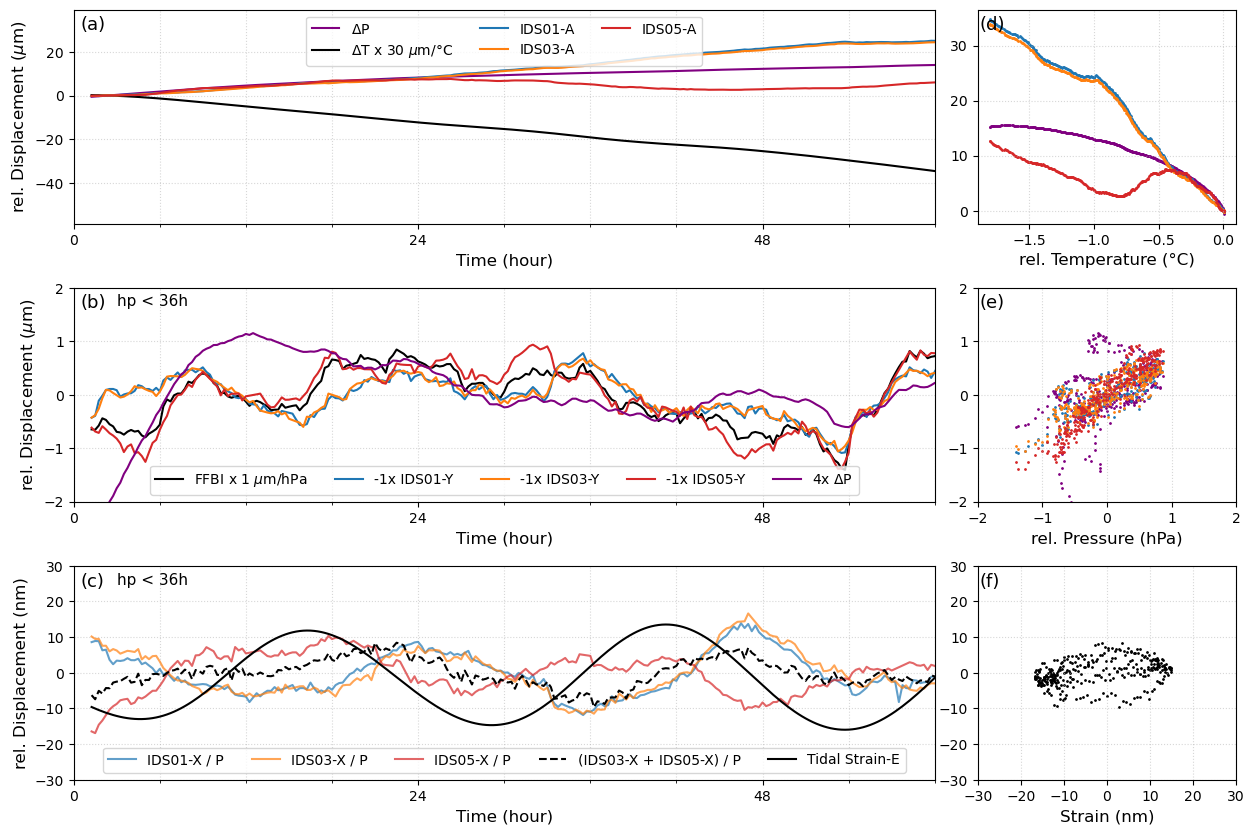

In [35]:
def __makeplot2():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from scipy.signal import detrend
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    # ___________________________________________

    tscale, tunit = 1/3600, "hour"

    reftime = df.time_utc.iloc[0]

    Ncol, Nrow = 8, 3

    font = 12

    fig = plt.figure(figsize=(15, 10))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.3, wspace=0.4)

    ax10 = fig.add_subplot(gs1[0, :6])
    ax11 = fig.add_subplot(gs1[0, 6:])
    ax20 = fig.add_subplot(gs1[1, :6])
    ax21 = fig.add_subplot(gs1[1, 6:])
    ax30 = fig.add_subplot(gs1[2, :6])
    ax31 = fig.add_subplot(gs1[2, 6:])

    axes0 = [ax10, ax20, ax30]
    axes1 = [ax11, ax21, ax31]

    # ___________________________________________

    ax10.plot(df.time_utc_sec*tscale, df.disp_um_rel,
              color="purple", label="$\Delta$P")
    ax10.plot(df.time_utc_sec*tscale, df.temp_sth_rel*30,
              color='k', label="$\Delta$T x 30 $\mu$m/°C")

    _fac = -3
    # ax10.plot(df.time_utc_sec*tscale, _fac*df.a_01_rel,
    #           color="tab:blue", label=f"{_fac}x IDS01-X")
    # ax10.plot(df.time_utc_sec*tscale, _fac*df.a_03_rel,
    #           color="tab:orange", label=f"{_fac}x IDS03-X")
    # ax10.plot(df.time_utc_sec*tscale, _fac*df.a_05_rel,
    #           color="tab:red", label=f"{_fac}x IDS05-X")

#     ax11.scatter(df.temp_sth_rel, df.disp_um_rel, s=1, color="purple")
#     ax11.scatter(df.temp_sth_rel, _fac*df.x_01_rel, s=1, color="tab:blue")
#     ax11.scatter(df.temp_sth_rel, _fac*df.x_03_rel, s=1, color="tab:orange")
#     ax11.scatter(df.temp_sth_rel, _fac*df.x_05_rel, s=1, color="tab:red")

    _fac = 1
    ax10.plot(df.time_utc_sec*tscale, _fac*df.a_01_rel,
              color="tab:blue", label= "IDS01-A")
    ax10.plot(df.time_utc_sec*tscale, _fac*df.a_03_rel,
              color="tab:orange", label="IDS03-A")
    ax10.plot(df.time_utc_sec*tscale, _fac*df.a_05_rel,
              color="tab:red", label="IDS05-A")

    ax11.scatter(df.temp_sth_rel, df.disp_um_rel, s=1, color="purple")
    ax11.scatter(df.temp_sth_rel, _fac*df.a_01_rel, s=1, color="tab:blue")
    ax11.scatter(df.temp_sth_rel, _fac*df.a_03_rel, s=1, color="tab:orange")
    ax11.scatter(df.temp_sth_rel, _fac*df.a_05_rel, s=1, color="tab:red")

    # ___________________________________________

    ax20.plot(df.time_utc_sec*tscale, stt.select(station="baro")[0].data,
              color='k', label="FFBI x 1 $\mu$m/hPa")
    ax20.plot(df.time_utc_sec*tscale, -stt.select(station="y_01")[0].data,
              color="tab:blue", label="-1x IDS01-Y")
    ax20.plot(df.time_utc_sec*tscale, -stt.select(station="y_03")[0].data,
              color="tab:orange", label="-1x IDS03-Y")
    ax20.plot(df.time_utc_sec*tscale, -stt.select(station="y_05")[0].data,
              color="tab:red", label="-1x IDS05-Y")
    _sfac = 4
    ax20.plot(df.time_utc_sec*tscale, stt.select(station="disp")[0].data*1e6*_sfac,
              color="purple", label=f"{_sfac}x $\Delta$P",
             )

    ax21.scatter(stt.select(station="baro")[0].data, stt.select(station="disp")[0].data*1e6*_sfac,
                 s=1, color="purple")
    ax21.scatter(stt.select(station="baro")[0].data, -stt.select(station="y_01")[0].data,
                 s=1, color="tab:blue")
    ax21.scatter(stt.select(station="baro")[0].data, -stt.select(station="y_03")[0].data,
                 s=1, color="tab:orange")
    ax21.scatter(stt.select(station="baro")[0].data, -stt.select(station="y_05")[0].data,
                 s=1, color="tab:red")

    # ___________________________________________

    ax30.plot(df.time_utc_sec*tscale, stt.select(station="x_01")[0].data/33.5*1e3,
              color="tab:blue", label="IDS01-X / P", alpha=0.7)
    ax30.plot(df.time_utc_sec*tscale, stt.select(station="x_03")[0].data/33.5*1e3,
              color="tab:orange", label="IDS03-X / P", alpha=0.7)
    ax30.plot(df.time_utc_sec*tscale, stt.select(station="x_05")[0].data/33.5*1e3,
              color="tab:red", label="IDS05-X / P", alpha=0.7)

    x_sum = stt.select(station="x_03")[0].data+stt.select(station="x_05")[0].data
    ax30.plot(df.time_utc_sec*tscale, x_sum/33.5*1e3,
              color="k", ls="--", label="(IDS03-X + IDS05-X) / P")

    ax30.plot(df.time_utc_sec*tscale, df.tideE*1e9, color='k', label="Tidal Strain-E")

    # ax30.plot(df.time_utc_sec*tscale, stt.select(station="disp")[0].data*1e6*33.5,
    #           color="purple", label=f"$\Delta$P",
    #          )

    # ax31.scatter(df.tideE*1e9, detrend(df.x_01, type="linear")/33.5*1e3,
    #              s=1, color="tab:blue")
    # ax31.scatter(df.tideE*1e9, detrend(df.x_03, type="linear")/33.5*1e3,
    #              s=1, color="tab:orange")
    # ax31.scatter( f.tideE*1e9, detrend(df.x_05, type="linear")/33.5*1e3,
    #              s=1, color="tab:red")

    ax31.scatter(df.tideE*1e9, x_sum/33.5*1e3,
                 s=1, color="k")

    # ax10.set_ylim(-5, 50)
    # ax11.set_ylim(-5, 50)

    ax20.set_ylim(-2, 2)
    ax21.set_ylim(-2, 2)
    ax21.set_xlim(-2, 2)

    ax30.set_ylim(-30, 30)
    ax31.set_ylim(-30, 30)
    ax31.set_xlim(-30, 30)

    for ax in axes0:
        ax.xaxis.set_major_locator(MultipleLocator(24))
        ax.xaxis.set_minor_locator(MultipleLocator(6))

    for _k, (ll, ax) in enumerate(zip(['(a)','(b)','(c)','(d)','(e)','(f)'], axes0+axes1)):
        ax.text(0.008, 0.97, ll, ha="left", va="top", transform=ax.transAxes, fontsize=font+1)

    for ax in axes0:
        ax.set_xlim(0, (config['tend']-config['tbeg']-86400)*tscale)
        ax.set_xlabel(f"Time ({tunit})", fontsize=font)
    for ax in axes0+axes1:
        ax.grid(ls=":", alpha=0.5, zorder=0, which="both")

    ax20.text(0.05, 0.97, f"hp < {int(1/fupper/3600)}h", ha="left", va="top", transform=ax20.transAxes, fontsize=font-1)
    ax30.text(0.05, 0.97, f"hp < {int(1/fupper/3600)}h", ha="left", va="top", transform=ax30.transAxes, fontsize=font-1)

    ax10.legend(loc=9, ncol=3)
    ax20.legend(loc=8, ncol=5)
    ax30.legend(loc=8, ncol=5)

    ax10.set_ylabel(f"rel. Displacement ($\mu$m)", fontsize=font)
    ax20.set_ylabel(f"rel. Displacement ($\mu$m)", fontsize=font)
    ax30.set_ylabel(f"rel. Displacement (nm)", fontsize=font)

    ax11.set_xlabel(f"rel. Temperature (°C)", fontsize=font)
    ax21.set_xlabel(f"rel. Pressure (hPa)", fontsize=font)
    ax31.set_xlabel(f"Strain (nm)", fontsize=font)

    plt.show();
    return fig

fig = __makeplot2()

# fig.savefig(config['path_to_figs']+f"FSR3_RZ_{config['tbeg']}_{config['tend']}_gps_analysis_hp.png",
#             format="png", dpi=150, bbox_inches='tight')


## Test

In [32]:
NE = np.cos(np.deg2rad(30))*df.tideN + np.sin(np.deg2rad(30))*df.tideE
NW = np.cos(np.deg2rad(30))*df.tideN + np.sin(np.deg2rad(30))*-1*df.tideE

_strain = ( NW + NE + df.tideE )

In [33]:
df['strain'] = _strain

df['disp_hp'] = np.interp(df.time_utc_sec, stx.select(station="FSR")[0].times(reftime=reftime), stx.select(station="FSR")[0].data)

df['baro_hp'] = np.interp(df.time_utc_sec, stx.select(station="FFBI")[0].times(reftime=reftime), stx.select(station="FFBI")[0].data)


NameError: name 'stx' is not defined

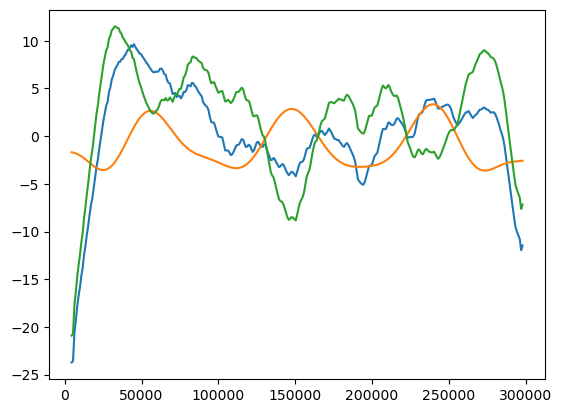

In [34]:
# plt.plot(df.time_utc_sec, df.disp_hp*1e6)
plt.plot(df.time_utc_sec, stt.select(station="disp")[0].data*1e6*33.5)

# plt.plot(df.time_utc_sec, df.baro_hp*0.2)

plt.plot(df.time_utc_sec, df.strain*1e9/10)

plt.plot(df.time_utc_sec, stt.select(station="disp")[0].data*1e6*33.5-df.strain*1e9/6)
